In [1]:
from flash_ansr import FlashANSR, GenerationConfig, install_model, get_path
 
import torch
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
from drawdata import ScatterWidget

In [3]:
MODEL = "psaegert/flash-ansr-v19.0-6M"

In [4]:
install_model(MODEL)

Installing model psaegert/flash-ansr-v19.0-6M to /home/psaegert/Projects/flash-ansr/models/psaegert/flash-ansr-v19.0-6M


Fetching 10 files:   0%|          | 0/10 [00:00<?, ?it/s]

Model psaegert/flash-ansr-v19.0-6M installed successfully!


In [5]:
nsr = FlashANSR.load(
    directory=get_path('models', MODEL),
    # generation_config=GenerationConfig(method='beam_search', beam_width=128 * 16, equivalence_pruning=True),
    generation_config=GenerationConfig(method='softmax_sampling', choices=1024 * 32, max_len=32),
    parsimony=0.05
).to(device)

In [6]:
widget = ScatterWidget()
widget

ScatterWidget()

In [19]:
X_raw, y_raw = widget.data_as_X_y

# Scale X_raw and y_raw to (-10, 10)
X = (X_raw - X_raw.min(axis=0)) / (X_raw.max(axis=0) - X_raw.min(axis=0)) * 20 - 10
y = (y_raw - y_raw.min(axis=0)) / (y_raw.max(axis=0) - y_raw.min(axis=0)) * 20 - 10

In [20]:
nsr.fit(X, y, verbose=True)

Fitting Constants: 100%|██████████| 7692/7692 [00:07<00:00, 990.74it/s] 


In [21]:
# nsr.compile_results(parsimony=0.01)

In [22]:
nsr.get_expression()

'(21.31 - (31.33 * cos((-215.22 + exp((x1 / -10.27))))))'

In [23]:
nsr.results

,log_prob,fvu,score,expression,complexity,target_complexity,numeric_prediction,raw_beam,beam,raw_beam_decoded,function,refiner,beam_id,fit_constants,fit_covariances,fit_loss
0,-14.262368,0.001571,-2.253830,"[-, <constant>, *, <constant>, cos, +, <consta...",11,None,None,"[1, 16, 6, 17, 6, 32, 15, 6, 37, 18, 47, 6, 2]","[16, 6, 17, 6, 32, 15, 6, 37, 18, 47, 6]","[-, <constant>, *, <constant>, cos, +, <consta...",<function <lambda> at 0x7f11d039e3e0>,"Refiner(expression=['-', '<constant>', '*', '<...",0,"[21.305639594497233, 31.32508233845714, -215.2...","[[0.6422976389978268, 0.6271199271187204, 0.00...",0.071547
1,-17.969834,0.002086,-2.130702,"[*, <constant>, +, <constant>, sin, *, <consta...",11,None,None,"[1, 17, 6, 15, 6, 31, 17, 6, 28, 16, 47, 6, 2]","[17, 6, 15, 6, 31, 17, 6, 28, 16, 47, 6]","[*, <constant>, +, <constant>, sin, *, <consta...",<function <lambda> at 0x7f11cfd9c860>,"Refiner(expression=['*', '<constant>', '+', '<...",1,"[-12.343861480954565, -0.2030516999459918, -2....","[[0.03310693291720457, 0.002110446956414174, -...",0.094999
2,-14.888882,0.012358,-1.508042,"[*, <constant>, cos, pow3, pow1_5, +, <constan...",8,None,None,"[1, 17, 6, 32, 24, 30, 15, 6, 47, 2]","[17, 6, 32, 24, 30, 15, 6, 47]","[*, <constant>, cos, pow3, pow1_5, +, <constan...",<function <lambda> at 0x7f11d02c2520>,"Refiner(expression=['*', '<constant>', 'cos', ...",2,"[9.811856971097495, 11.018392415684731]","[[0.02093391231757466, 4.696455951728985e-05],...",0.562831
3,-33.543836,0.010312,-1.386671,"[+, *, <constant>, +, <constant>, x1, *, <cons...",12,None,None,"[1, 15, 17, 6, 15, 6, 47, 17, 6, 37, 17, 6, 47...","[15, 17, 6, 15, 6, 47, 17, 6, 37, 17, 6, 47]","[+, *, <constant>, +, <constant>, x1, *, <cons...",<function <lambda> at 0x7f11cf580180>,"Refiner(expression=['+', '*', '<constant>', '+...",3,"[1.6773011058564447, -3.3777289769167846, 0.75...","[[0.0017600315414097033, -0.002643656487003386...",0.469623
4,-23.452156,0.010312,-1.386671,"[+, <constant>, +, *, <constant>, x1, *, <cons...",12,None,None,"[1, 15, 6, 15, 17, 6, 47, 17, 6, 37, 17, 6, 47...","[15, 6, 15, 17, 6, 47, 17, 6, 37, 17, 6, 47]","[+, <constant>, +, *, <constant>, x1, *, <cons...",<function <lambda> at 0x7f11cf8bbce0>,"Refiner(expression=['+', '<constant>', '+', '*...",4,"[-5.665475593128215, 1.6773020756942734, 0.757...","[[0.08246576512219982, -0.010378810561324068, ...",0.469623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7687,-39.046749,NaN,NaN,"[+, <constant>, *, <constant>, +, x1, acos, /,...",17,None,None,"[1, 15, 6, 17, 6, 15, 47, 35, 18, 6, 18, 47, 1...","[15, 6, 17, 6, 15, 47, 35, 18, 6, 18, 47, 15, ...","[+, <constant>, *, <constant>, +, x1, acos, /,...",<function <lambda> at 0x7f11cf5828e0>,"Refiner(expression=['+', '<constant>', '*', '<...",7687,"[2.4928144704583852, 4.125691761738969, 0.6235...","[[inf, inf, inf, inf], [inf, inf, inf, inf], [...",NaN
7688,-39.717564,NaN,NaN,"[+, <constant>, *, <constant>, *, cos, pow1_3,...",16,None,None,"[1, 15, 6, 17, 6, 17, 32, 28, 47, 37, 18, 6, 2...","[15, 6, 17, 6, 17, 32, 28, 47, 37, 18, 6, 25, ...","[+, <constant>, *, <constant>, *, cos, pow1_3,...",<function <lambda> at 0x7f11cf581a80>,"Refiner(expression=['+', '<constant>', '*', '<...",7688,"[1.2911917880293355, 2.3656937394940316, 0.929...","[[inf, inf, inf], [inf, inf, inf], [inf, inf, ...",inf
7689,-39.766124,NaN,NaN,"[+, <constant>, -, *, +, <constant>, x1, pow1_...",15,None,None,"[1, 15, 6, 16, 17, 15, 6, 47, 27, 31, 29, 17, ...","[15, 6, 16, 17, 15, 6, 47, 27, 31, 29, 17, 6, ...","[+, <constant>, -, *, +, <constant>, x1, pow1_...",<function <lambda> at 0x7f11cf581620>,"Refiner(expression=['+', '<constant>', '-', '*...",7689,"[1.3130105036944952, 2.5292804614967865, 3.053...","[[inf, inf, inf], [inf, inf, inf], [inf, inf, ...",NaN
7690,-42.190765,NaN,NaN,"[+, <constant>, +, x1, +, exp, exp, *, <consta...",18,None,None,"[1, 15, 6, 15, 47, 15, 37, 37, 17, 6, 47, 16, ...","[15, 6, 15, 47, 15, 37, 37, 17, 6, 47, 16, 21,...","[+, <co

In [24]:
X_linspace = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)

In [25]:
y_pred = [[nsr.predict(X, nth_best_beam=beam_id, nth_best_constants=fit_id) for fit_id in range(len(result['fits'])) if np.isfinite(result['score'])] for beam_id, result in enumerate(nsr._results)]
y_pred_linspace = [[nsr.predict(X_linspace, nth_best_beam=beam_id, nth_best_constants=fit_id) for fit_id in range(len(result['fits'])) if np.isfinite(result['score'])] for beam_id, result in enumerate(nsr._results)]

/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.13/site-packages/simplipy/operators.py:113: RuntimeWarning: invalid value encountered in power
  x = np.where(x < 0, -(-x) ** (1 / 3), x ** (1 / 3))
/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.13/site-packages/simplipy/operators.py:154: RuntimeWarning: invalid value encountered in power
  x = np.where(x < 0, -(-x) ** (1 / 5), x ** (1 / 5))
/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.13/site-packages/simplipy/operators.py:489: RuntimeWarning: overflow encountered in exp
  return np.exp(x)
/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.13/site-packages/simplipy/operators.py:30: RuntimeWarning: divide by zero encountered in divide
  return x / y
/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.13/site-packages/simplipy/operators.py:98: RuntimeWarning: overflow encountered in power
  return x ** 5


In [26]:
y_pred = y_pred[:32]
y_pred_linspace = y_pred_linspace[:32]

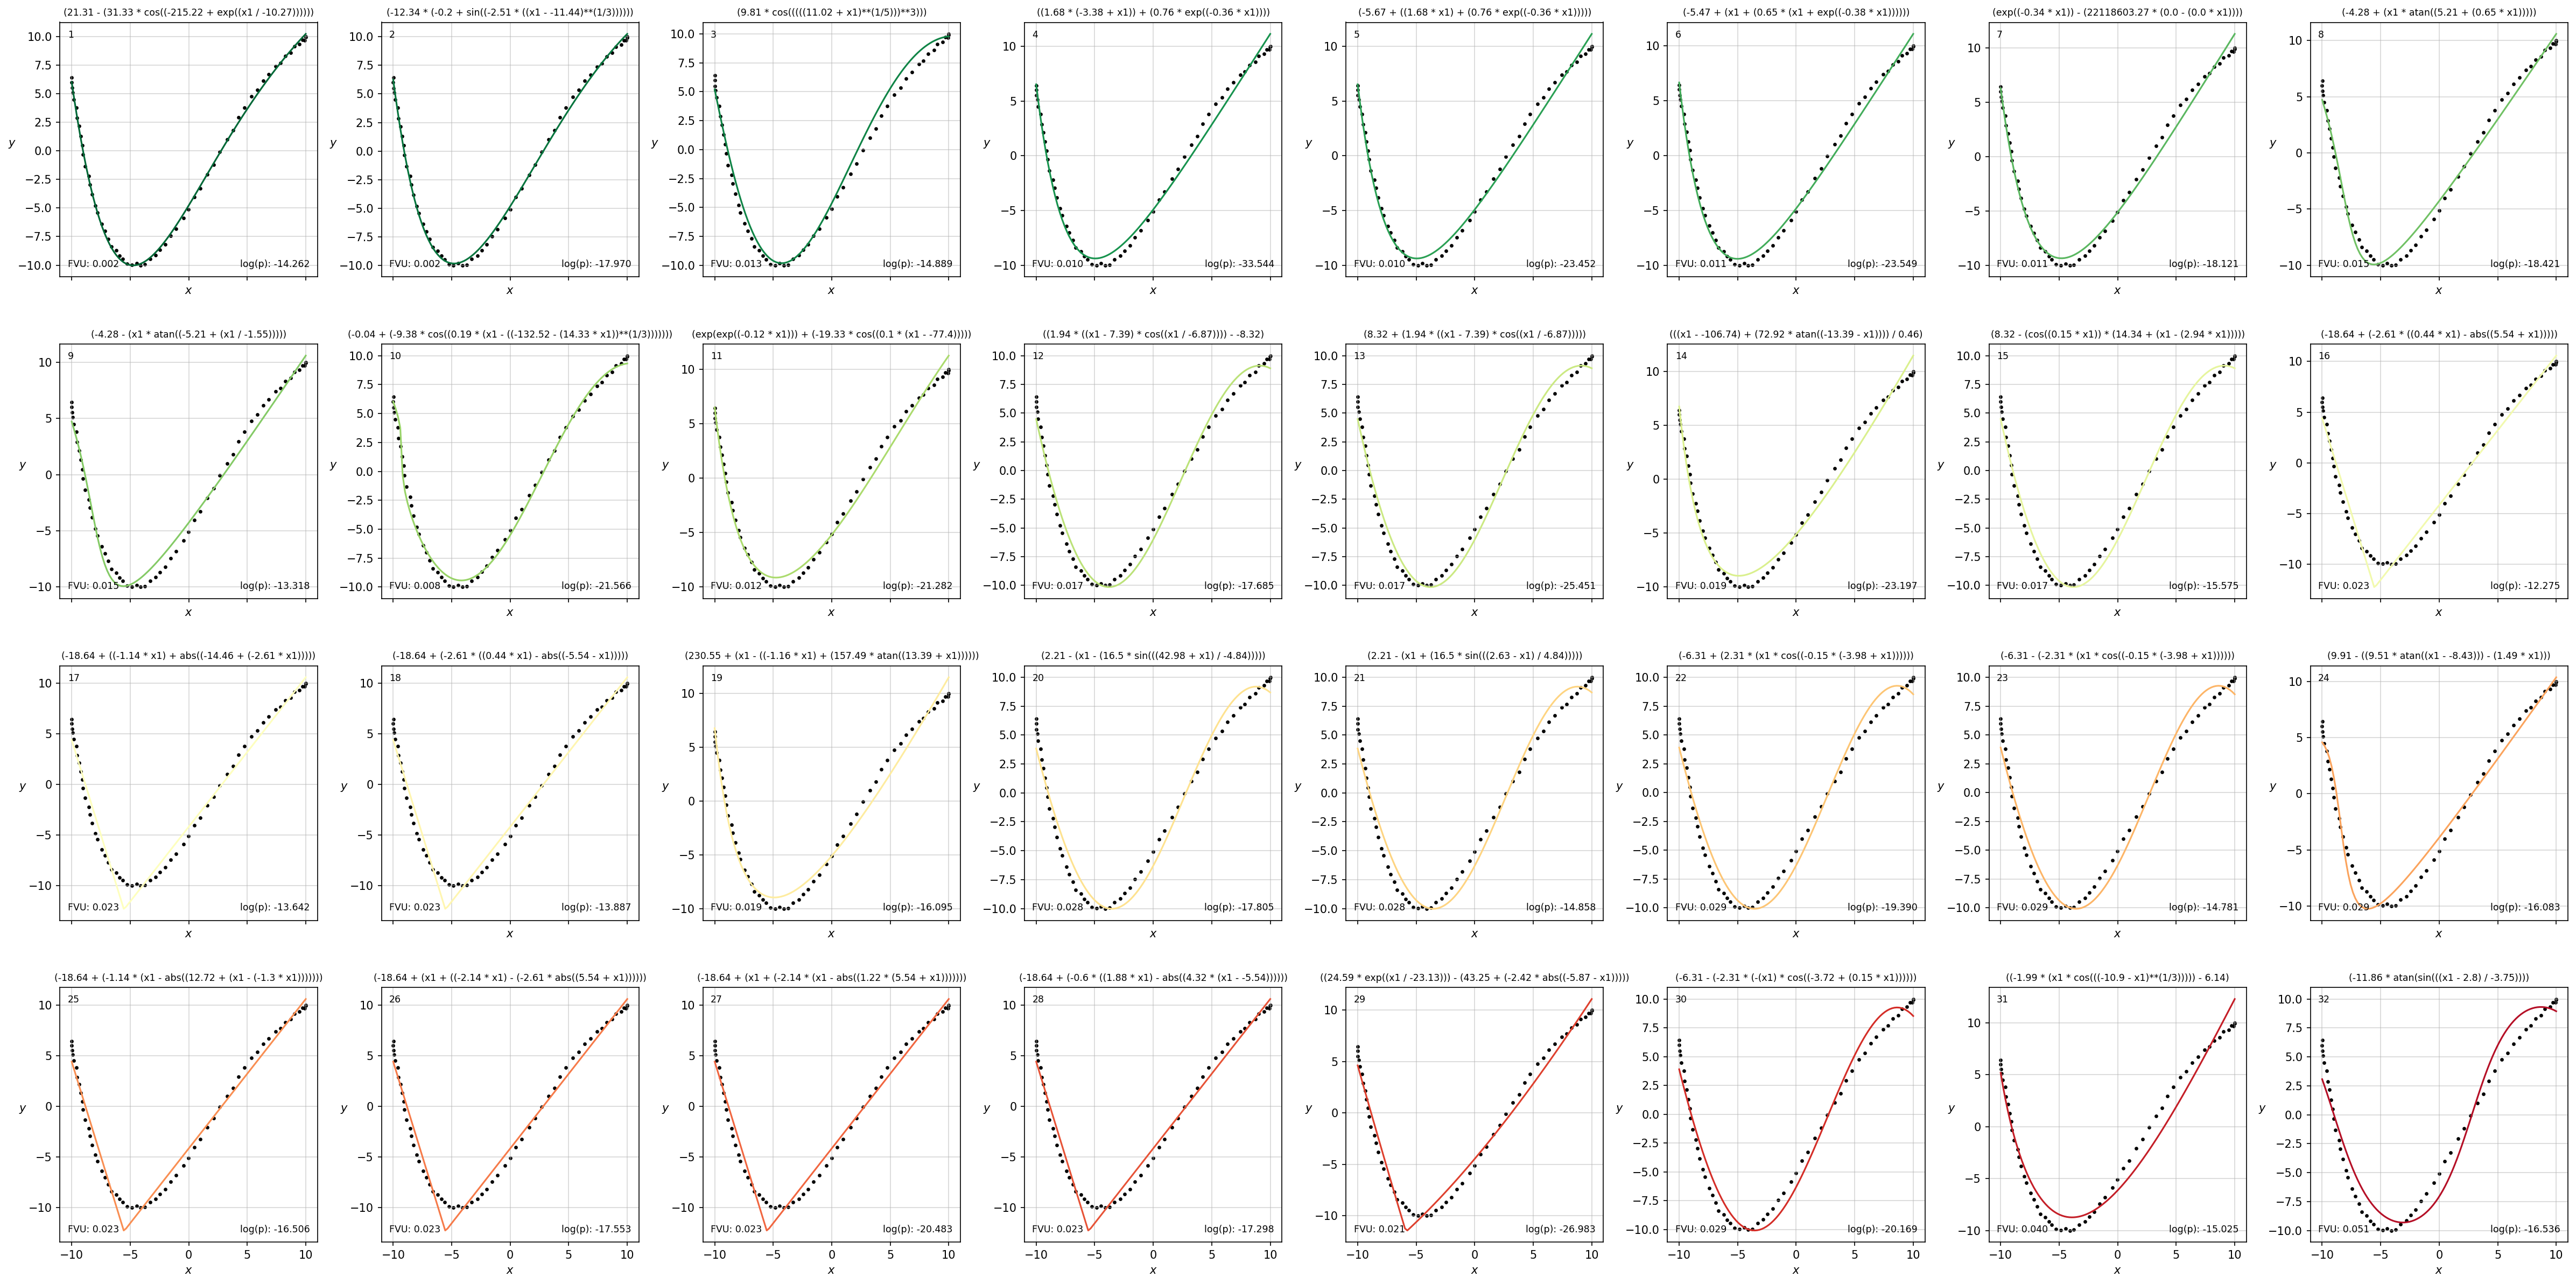

In [27]:
COLS = 8
ROWS = np.ceil(len(y_pred) / COLS).astype(int)

fig, axs = plt.subplots(ROWS, COLS, figsize=(COLS * 4, ROWS * 4), dpi=150, sharex=True)

for i, ax in enumerate(axs.flat):
    if i >= len(y_pred) or len(y_pred[i]) == 0:
        ax.axis('off')
        continue
    fvu = np.mean((y_pred[i][0][:, 0] - y)**2) / np.var(y)
    expression_pred_transformed = nsr._results[i]['refiner'].transform(nsr._results[i]['expression'], 0, return_prefix=True)
    expression_pred_transformed_infix = nsr.simplipy_engine.prefix_to_infix(expression_pred_transformed, power='**')

    ax.plot(X_linspace, y_pred_linspace[i][0], color=plt.get_cmap('RdYlGn')(1 - i / len(y_pred)))
    ax.scatter(X, y, color='k', s=5)
    ax.set_title(expression_pred_transformed_infix, fontsize='small')
    
    ax.annotate(f'{i + 1}', xy=(0.03, 0.97), xycoords='axes fraction', ha='left', va='top', fontsize='small')
    ax.annotate(f'FVU: {fvu:.3f}', xy=(0.03, 0.03), xycoords='axes fraction', ha='left', va='bottom', fontsize='small')
    ax.annotate(f'log(p): {nsr._results[i]["log_prob"]:.3f}', xy=(0.97, 0.03), xycoords='axes fraction', ha='right', va='bottom', fontsize='small')

    ax.grid(alpha=0.5)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$', rotation=0, labelpad=5)

fig.tight_layout(h_pad=3)

Text(0, 0.5, 'Complexity')

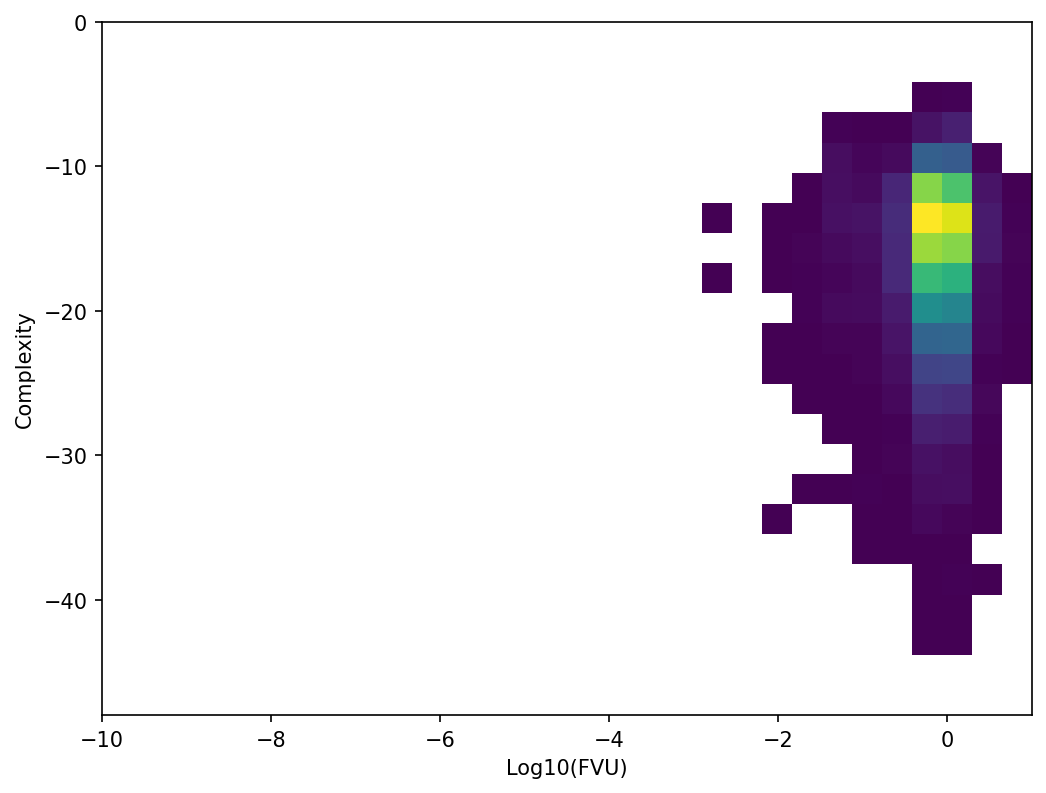

In [ ]:
# plot the fvu against the complexity
fig, ax = plt.subplots(figsize=(8, 6), dpi=150)
ax.hist2d(np.log10(nsr.results['fvu']), nsr.results['log_prob'], bins=(np.linspace(-10, 1, 32), np.linspace(-48, 0, 24)), cmin=1);
ax.set_xlabel('Log10(FVU)')
ax.set_ylabel('Log Probability')

/home/psaegert/miniconda3/envs/flash-ansr/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: The behavior of Series.argsort in the presence of NA values is deprecated. In a future version, NA values will be ordered last instead of set to -1.
  return bound(*args, **kwds)


Text(0, 0.5, 'Log Probability')

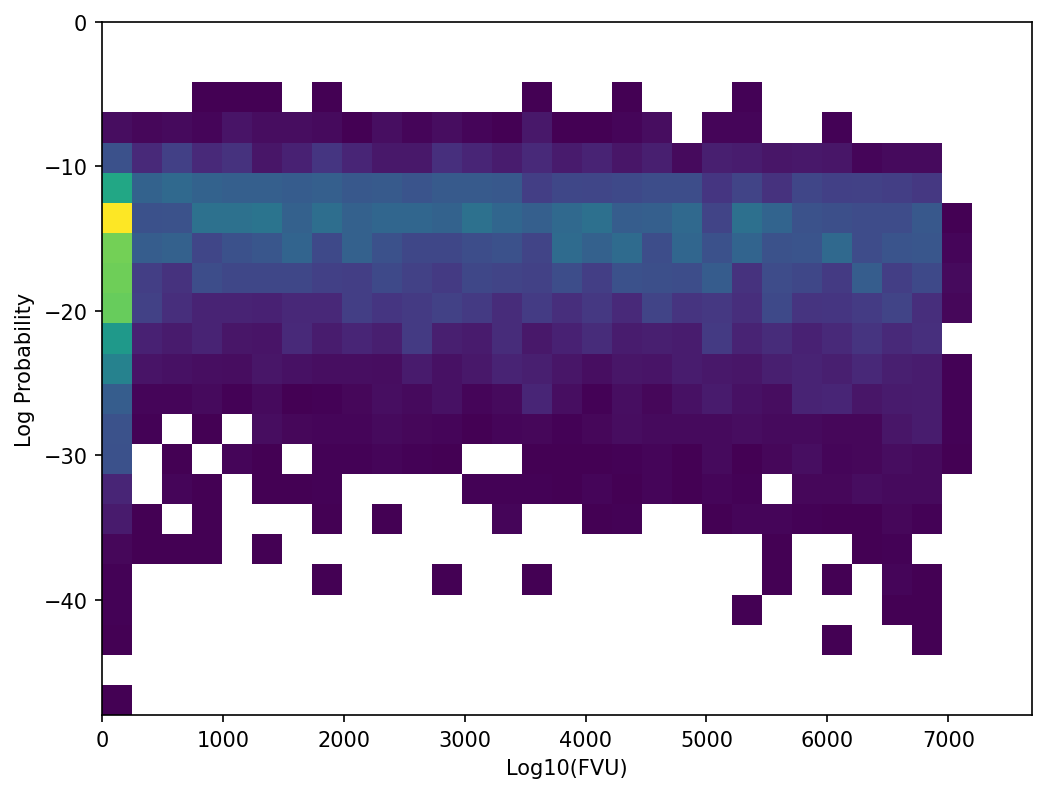

In [47]:
# plot the fvu against the complexity
fig, ax = plt.subplots(figsize=(8, 6), dpi=150)
ax.hist2d(np.argsort(nsr.results['fvu']), nsr.results['log_prob'], bins=(np.linspace(-1, len(nsr.results), 32), np.linspace(-48, 0, 24)), cmin=1);
ax.set_xlabel('Log10(FVU)')
ax.set_ylabel('Log Probability')

Text(0, 0.5, 'Complexity')

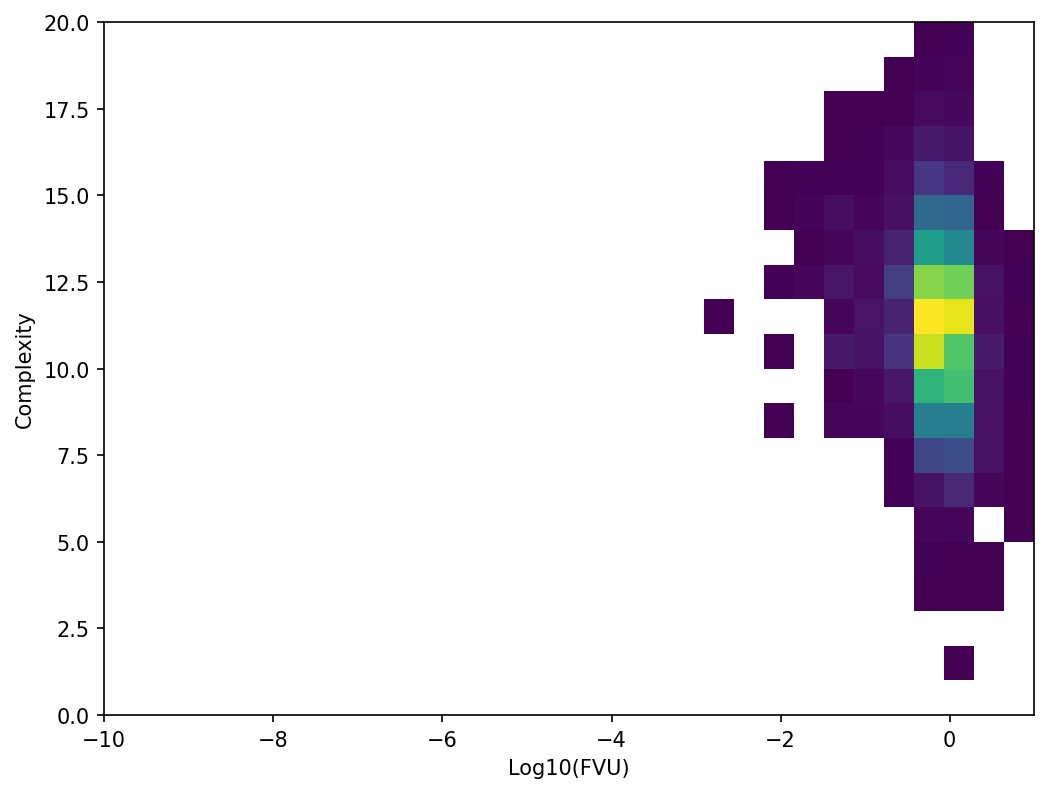

In [ ]:
# plot the fvu against the complexity
fig, ax = plt.subplots(figsize=(8, 6), dpi=150)
ax.hist2d(np.log10(nsr.results['fvu']), nsr.results['complexity'], bins=(np.linspace(-10, 1, 32), np.linspace(0, 20, 21)), cmin=1);
ax.set_xlabel('Log10(FVU)')
ax.set_ylabel('Complexity')